In [2]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import timeit
from scipy.stats import norm,kstest,shapiro,t
import seaborn as sns
import pylab



# Problem 1
###### Use the stock returns in DailyReturn.csv for this problem. 
###### DailyReturn.csv contains returns for 100 large US stocks and as well as the ETF, SPY which tracks the S&P500.
###### Create a routine for calculating an exponentially weighted covariance matrix. 
###### If you have a package that calculates it for you, verify that it calculates the values you expect.This means you still have to implement it.
###### Use PCA and plot the cumulative variance explained by each eigenvalue for λ each chosen.


In [65]:
df = pd.read_csv("DailyReturn.csv")
df = df.drop(axis = 1,labels = "Unnamed: 0")
print(df)


         SPY      AAPL      MSFT      AMZN      TSLA     GOOGL      GOOG  \
0   0.002608  0.001474  0.010897  0.005842  0.032571  0.000825  0.002566   
1  -0.001036 -0.005285 -0.005149 -0.028955  0.017539 -0.030443 -0.029104   
2   0.005363 -0.000336 -0.003332 -0.004551  0.126616 -0.000869  0.001068   
3   0.000900  0.004575  0.006426  0.016775 -0.006274  0.013543  0.006478   
4  -0.004430 -0.003148  0.042114  0.004864  0.019078  0.049595  0.048367   
5   0.009649  0.024992  0.003651  0.015941  0.037751 -0.002520 -0.002039   
6   0.002029 -0.018156  0.022414 -0.021511  0.034316  0.015064  0.014655   
7   0.001720 -0.005607 -0.006785 -0.016107  0.084910 -0.030727 -0.030326   
8   0.004043  0.007116  0.011416 -0.001615 -0.030275  0.013488  0.014530   
9   0.006105  0.009799  0.002611  0.021508  0.035717  0.008014  0.006355   
10  0.004713 -0.003499  0.007305  0.027482  0.013222  0.011388  0.012896   
11  0.003470  0.003582 -0.001129  0.012077 -0.006358  0.003942  0.003753   
12  0.000854

In [120]:
def wei(x, y, weight):
    mean_x = np.average(x, weights=weight)
    mean_y = np.average(y, weights=weight)
    cov = np.average((x - mean_x) * (y - mean_y), weights=weight)
    return cov

def calculate_weight(lamb, df):
    val = df.index.values
    weight = [(1-lamb) * lamb**(i-1) for i in range(len(val))]
    weight_adjust = [w/sum(weight) for w in weight]
    return weight_adjust

def weighted_cov(lamb, df):

    col = df.shape[1]
    weight = calculate_weight(lamb, df)
    cov_mat = pd.DataFrame(np.zeros((col, col)))
    for i in range(col):
        cov_mat.iloc[i, i] = wei(df.iloc[:, i], df.iloc[:, i], weight)
        for j in range(i+1):
            cov_mat.iloc[i, j] = wei(df.iloc[:, i], df.iloc[:, j], weight)
            cov_mat.iloc[j, i] = cov_mat.iloc[i, j]

    return np.array(cov_mat)

In [122]:
# Use PCA to calculate the cumulative variance
def PCA(cov_matrix):
    eigenvalue = np.linalg.eigh(cov_matrix)[0]
    eigenvalue = sorted(eigenvalue, reverse = True)
    total_eigen = np.sum(eigenvalue)
    pct_list = []
    non_zero = 0

    for i in range(len(eigenvalue)):
        if eigenvalue[i] < 0:
            break
        non_zero = eigenvalue[i] + non_zero
        pct_list.append(non_zero/total_eigen)
    return np.array(pct_list)


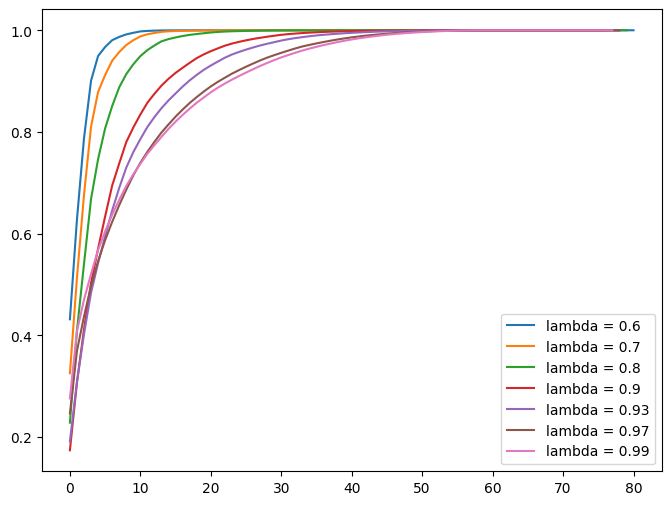

In [138]:
lam = [0.6, 0.7, 0.8, 0.90, 0.93, 0.97, 0.99]
fig, ax = plt.subplots(figsize=(8,6))

for lam in lam:
    cov_mat = weighted_cov(lam, df)
    PCA_list = PCA(cov_mat)
    ax.plot(PCA_list, label = f"lambda = {lam}")
ax.legend(loc='best')

# Problem2

Copy the chol_psd(), and near_psd() functions from the course repository – implement in your
programming language of choice.  These are core functions you will need throughout the
remainder of the class.
Implement Higham’s 2002 nearest psd correlation function.
Generate a non-psd correlation matrix that is 500x500.
Use near_psd() and Higham’s method to fix the matrix.  Confirm the matrix is now PSD.
Compare the results of both using the Frobenius Norm.  Compare the run time between the two.
How does the run time of each function compare as N increases?
Based on the above, discuss the pros and cons of each method and when you would use each.
There is no wrong answer here, I want you to think through this and tell me what you think.

In [91]:
# cholesky decomposition
def chol_psd(matrix):
    le = len(matrix)
    ze = -1e-8
    root = np.array([[0.0] * le for _ in range(le)])
    for j in range(le):
        s = root[j,:j]@root[j,:j].T
        temp = matrix[j,j] - s
        if 0 >= temp >= ze:
            temp = 0.0
        elif temp < ze:
            raise ValueError("non-PSD")
        root[j,j] = np.sqrt(temp)
        if root[j,j] == 0:
            continue
        for i in range(j+1,le):
            s = root[i,:j]@root[j,:j]
            root[i,j] =(matrix[i,j] - s)*1.0/root[j,j]
    return root

In [79]:
# Rebonato and Jackel
def near_psd(matrix, epsilon=0.0):

    n = matrix.shape[0]
    invSD = None
    out = matrix.copy()
    if np.count_nonzero(np.diag(out) == 1.0) != n:
        invSD = np.diag(1 / np.sqrt(np.diag(out)))
        out = np.matmul(np.matmul(invSD, out), invSD)

    vals, vecs = np.linalg.eigh(out)
    vals = np.maximum(vals, epsilon)
    T = np.reciprocal(np.matmul(np.square(vecs), vals))
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = np.matmul(np.matmul(T, vecs), l)
    out = np.matmul(B, np.transpose(B))

    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        out = np.matmul(np.matmul(invSD, out), invSD)

    return out

In [130]:
# Higham
def proj_u(matrix):
    cor = matrix.copy()
    np.fill_diagonal(cor,1)
    return cor

def Frobenius_norm(matrix):
    return np.linalg.norm(matrix, 'fro')**2

def proj_s(matrix):
    eig_val, eig_vec = np.linalg.eigh(matrix)
    eig_val[eig_val<0] = 0
    p = eig_vec@ np.diagflat(eig_val)@eig_vec.T
    return p


def Higham_near_psd(matrix):
    dS = 0
    Y = matrix
    last_gamma = float("inf")
    iteration = 100000
    tol = 1e-10

    for i in range(iteration):
        R = Y - dS                      
        X = proj_s(R)                   
        dS = X - R                       
        Y = proj_u(X)                   
        gamma = Frobenius_norm(Y - matrix)   
        if abs(gamma-last_gamma)< tol:  
            break
        last_gamma = gamma
    return Y

In [131]:
# non-psd correlation matrix
def generate_nonpsd_matrix(n):
    corr = np.full((n,n),0.9)
    np.fill_diagonal(corr, 1)
    corr[0,1] = 0.7357
    corr[1,0] = 0.7357 
    return corr

corr = generate_nonpsd_matrix(500)
corr

array([[1.    , 0.7357, 0.9   , ..., 0.9   , 0.9   , 0.9   ],
       [0.7357, 1.    , 0.9   , ..., 0.9   , 0.9   , 0.9   ],
       [0.9   , 0.9   , 1.    , ..., 0.9   , 0.9   , 0.9   ],
       ...,
       [0.9   , 0.9   , 0.9   , ..., 1.    , 0.9   , 0.9   ],
       [0.9   , 0.9   , 0.9   , ..., 0.9   , 1.    , 0.9   ],
       [0.9   , 0.9   , 0.9   , ..., 0.9   , 0.9   , 1.    ]])

Input:
N: list of integers representing matrix sizes
near_psd: function for generating a near-positive semi-definite matrix from a non-positive semi-definite matrix
Higham_near_psd: function for generating a near-positive semi-definite matrix from a non-positive semi-definite matrix using the Higham method
generate_nonpsd_matrix: function for generating a non-positive semi-definite matrix of given size
Frobenius_norm: function for computing the Frobenius norm of a matrix

Output:
Two pandas DataFrames (runtime_data and norm_data) and a matplotlib plot

Description:
- For each matrix size in N, the code generates a non-positive semi-definite matrix of that size using generate_nonpsd_matrix.
- It then computes the run time and Frobenius norm of the near-positive semi-definite matrices generated by both near_psd and Higham_near_psd functions applied to the non-positive semi-definite matrix.
- The run time and Frobenius norm results are stored in two pandas DataFrames (runtime_data and norm_data).
- The runtime_data and norm_data are plotted using matplotlib in a single plot with two subplots.


In [132]:
def check_psd(matrix):
    eigenvalues = np.linalg.eigh(matrix)[0]
    return np.all(eigenvalues >= -1e-8)

In [133]:
# check the matrix is now PSD
cor = check_psd(corr)
nea = check_psd(near_psd(corr))
hig = check_psd(Higham_near_psd(corr))
print(cor,nea,hig)

False True True


In [127]:
def measure_runtime(input_f, *args, **kwargs):
    start = timeit.default_timer()
    result = input_f(*args, **kwargs)
    
    stop = timeit.default_timer()
    return result, stop - start

(         Near_runtime  Higham_runtime
 N = 5        0.000186        0.000244
 N = 10       0.000288        0.003070
 N = 30       0.000930        0.021107
 N = 60       0.001161        0.039708
 N = 150      0.005163        0.139836
 N = 300      0.030297        1.168344
 N = 400      0.078654        1.302942
 N = 500      0.052028        1.202105,
            Near_fnorm  Higham_fnorm
 N = 5    1.465220e-10  9.086644e-11
 N = 10   2.738548e-03  1.519233e-03
 N = 30   1.850219e-02  5.062109e-03
 N = 60   4.246761e-02  6.501064e-03
 N = 150  1.143417e-01  7.517246e-03
 N = 300  2.341064e-01  7.885194e-03
 N = 400  3.139460e-01  7.979625e-03
 N = 500  3.937847e-01  8.036763e-03)

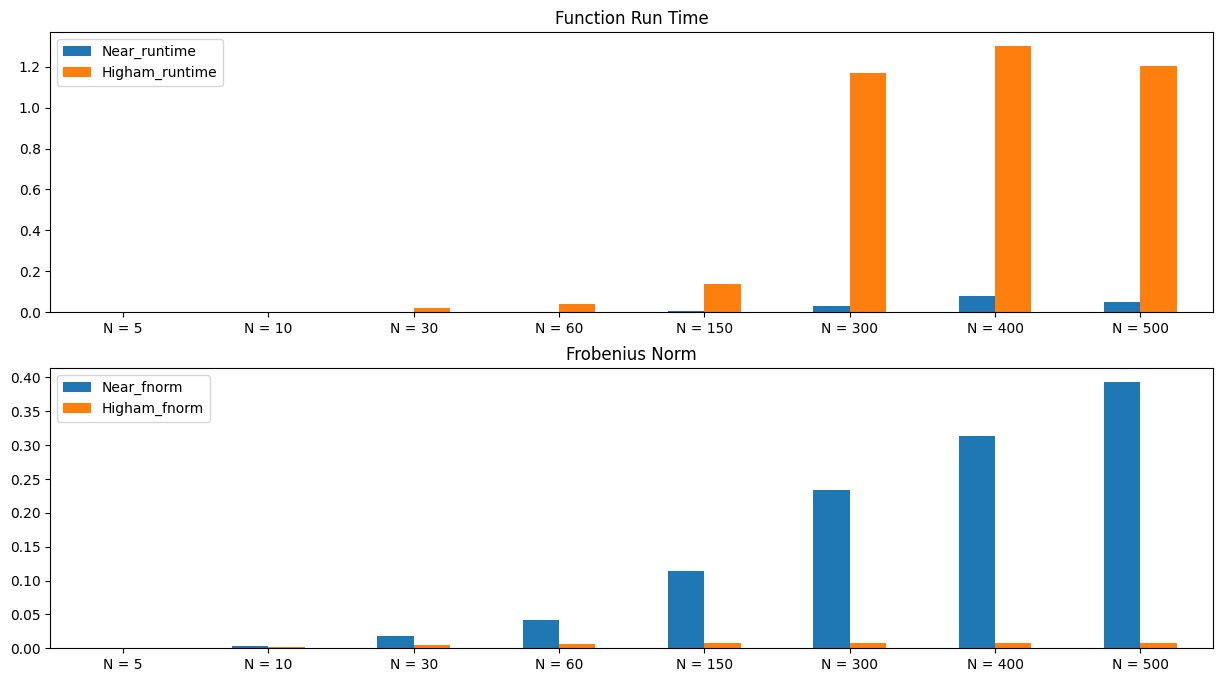

In [134]:
def compare_methods(N, near_psd, Higham_near_psd, generate_nonpsd_matrix, Frobenius_norm):
    Near_runtimes = []
    Higham_runtimes = []
    Near_fnorms = []
    Higham_fnorms = []
    
    for size in N:
        nonpsd_mat = generate_nonpsd_matrix(size)
        result1, time1 = measure_runtime(near_psd, nonpsd_mat)
        Near_runtimes.append(time1)
        norm1 = Frobenius_norm(result1 - nonpsd_mat)
        Near_fnorms.append(norm1)
        
        result2, time2 = measure_runtime(Higham_near_psd, nonpsd_mat)
        Higham_runtimes.append(time2)
        norm2 = Frobenius_norm(result2 - nonpsd_mat)
        Higham_fnorms.append(norm2)
        
    label = ["N = " + str(n) for n in N]
    runtime_data = pd.DataFrame({
        "Near_runtime": Near_runtimes,
        "Higham_runtime": Higham_runtimes
    }, index=label)
    
    norm_data = pd.DataFrame({
        "Near_fnorm": Near_fnorms,
        "Higham_fnorm": Higham_fnorms
    }, index=label)
    
    fig, axes = plt.subplots(2, 1, figsize=(3*len(N), 3*len(N)))
    runtime_data.plot.bar(rot=0, figsize=(15, 8), ax=axes[0], title="Function Run Time")
    norm_data.plot.bar(rot=0, figsize=(15, 8), ax=axes[1], title="Frobenius Norm")
    return  runtime_data, norm_data

N = [5, 10, 30, 60, 150, 300, 400, 500]
compare_methods(N, near_psd, Higham_near_psd, generate_nonpsd_matrix, Frobenius_norm)

# Problem 3
Implement a multivariate normal simulation that allows for simulation directly from a covariance matrix or using PCA with an optional parameter for % variance explained.  If you have a library
that can do these, you still need to implement it yourself for this homework and prove that itfunctions as expected.
Generate a correlation matrix and variance vector 2 ways:
1. Standard Pearson correlation/variance (you do not need to reimplement the cor() and
var() functions).
2. Exponentially weighted λ=0.97
Combine these to form 4 different covariance matrices.  
(Pearson correlation + var()), Pearson correlation + EW variance,etc.)
Simulate 25,000 draws from each covariance matrix using:
1. Direct Simulation
2. PCA with 100% explained.
3. PCA with 75% explained.
4. PCA with 50% explained.
Calculate the covariance of the simulated values.  Compare the simulated covariance to it’s input matrix using the Frobenius Norm (L2 norm, sum of the square of the difference between the matrices).  Compare the run times for each simulation.
What can we say about the trade offs between time to run and accuracy.

In [135]:
def cal_std(cov_mat):
    std = np.sqrt(np.diag(cov_mat))
    return std
def cal_corr(cov_mat):
    std = cal_std(cov_mat)
    return np.diag(1/std)@cov_mat@(np.diag(1/std)).T

def cal_cov(std, corr):
    std = np.diag(std)
    return std@corr@std.T

def Cho_simulate_data(cov_mat, sample_num):
    rand_data = np.random.normal(size = (cov_mat.shape[0],sample_num))
    L = chol_psd(cov_mat)
    return np.matmul(L, rand_data)

def PCA_simulate_data(cov_mat, explained, sample_num):
    eigenvalue, eigenvector = np.linalg.eigh(cov_mat)
    explained_var = np.cumsum(eigenvalue[::-1]) / np.sum(eigenvalue)
    ix = np.argmax(explained_var >= explained)
    eigenvector = eigenvector[:, -(ix+1):]
    L = eigenvector @ np.diag(np.sqrt(eigenvalue[-(ix+1):]))
    rand_data = np.random.normal(size = (L.shape[1], sample_num))
    return L @ rand_data

In [136]:
da = pd.read_csv("DailyReturn.csv").iloc[:, 1:]
df_T = da.T
oriCov = np.cov(df_T)
oriStd = cal_std(oriCov)
oriCorr = cal_corr(oriCov)

ewCov = weighted_cov(0.97, da)
ewStd = cal_std(ewCov)
ewCorr = cal_corr(ewCov)

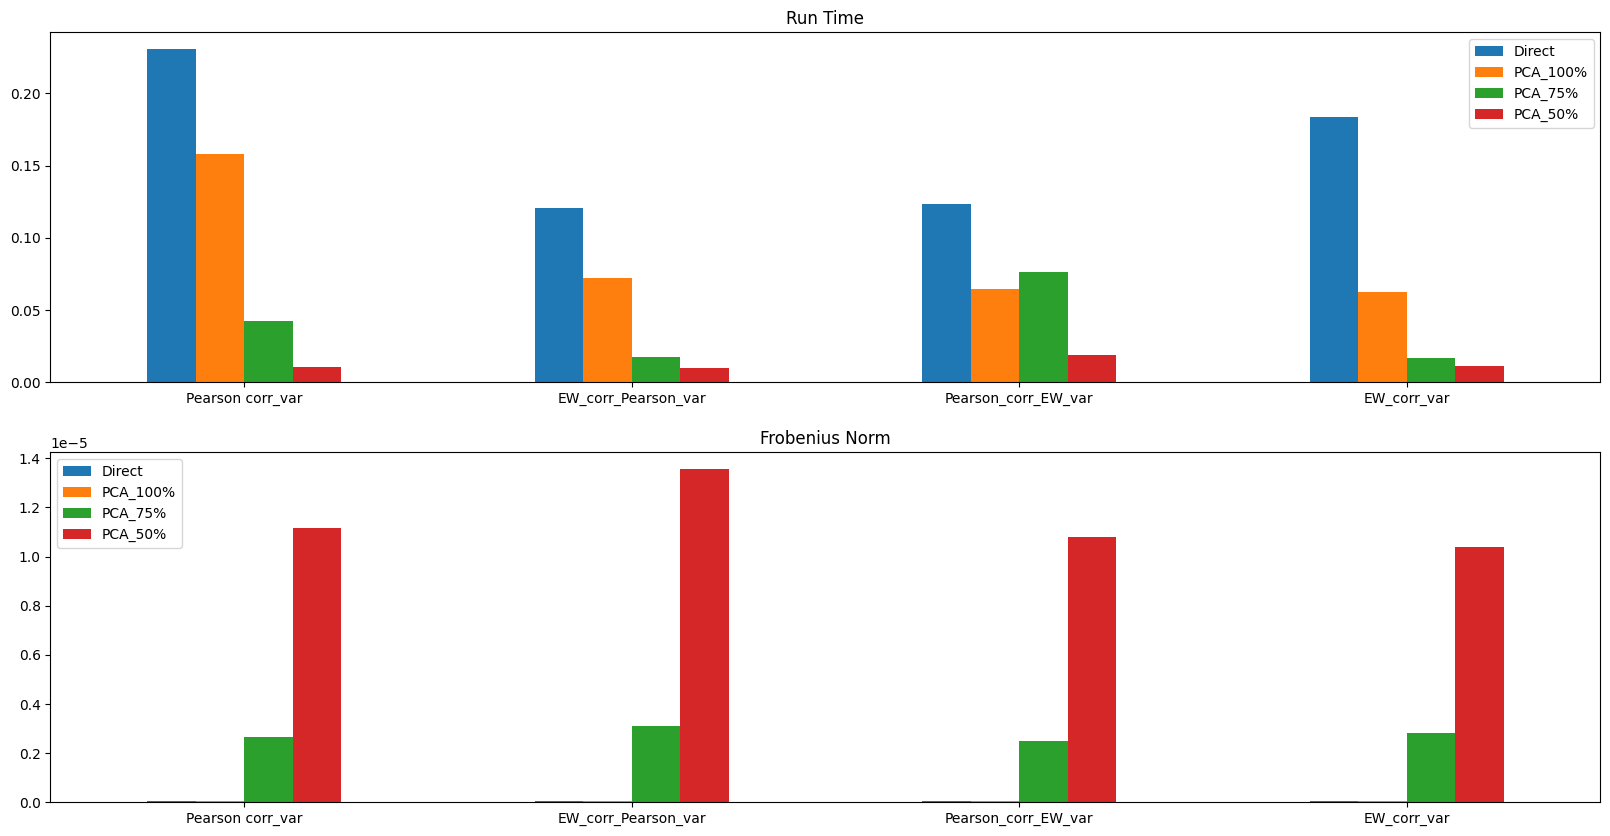

In [137]:
co_cov = [cal_cov(oriStd, oriCorr), cal_cov(oriStd, ewCorr), cal_cov(ewStd, oriCorr), cal_cov(ewStd, ewCorr)]
method_labels = ["Pearson corr_var", "EW_corr_Pearson_var", "Pearson_corr_EW_var", "EW_corr_var"]
sim_labels = ["Direct", "PCA_100%", "PCA_75%", "PCA_50%"]

time_li = []
norm_li = []
ran = [1.0, 0.75, 0.5]
for cov in co_cov:
    timer = []
    norms = []
    res_direct, time_direct = measure_runtime(Cho_simulate_data, cov, 25000)
    timer.append(time_direct)
    norms.append(Frobenius_norm(np.cov(res_direct) - cov))
    
    for p in ran:
        res_pca, time_pca = measure_runtime(PCA_simulate_data, cov, p, 25000)
        timer.append(time_pca)
        norms.append(Frobenius_norm(np.cov(res_pca) - cov))
        
    time_li.append(timer)
    norm_li.append(norms)
        
TimeSim_df = pd.DataFrame(time_li, index=method_labels, columns=sim_labels)
NormSim_df = pd.DataFrame(norm_li, index=method_labels, columns=sim_labels)

fig, axes = plt.subplots(2, 1, figsize=(3*len(N), 3*len(N)))
TimeSim_df.plot.bar(rot=0, figsize=(20, 10), ax=axes[0], title="Run Time")
NormSim_df.plot.bar(rot=0, figsize=(20, 10), ax=axes[1], title="Frobenius Norm")
plt.show()
